# Análisis exploratorio de los datos

El objetivo de este notebook es realizar un análisis de datos de nuestro dataset de Kaggle: https://www.kaggle.com/datasets/puneetbhaya/online-retail

Se irá explorando los distintos campos de interés para luego tomar decisiones de preparación del dataset para el modelado.

In [1]:
import pandas as pd

In [2]:
# Se bajó el archivo que tiene el formato de .xlsx
df = pd.read_excel("C:/Users/josefina.lin/Documents/Master/10-Trabajo Final/datasets/Online Retail.xlsx")

Al ordenar el dataframe por el primer campo (`InvoiceNo`), se empieza a dilucidar el significado de los campos:
* `InvoiceNo`: identificador de la transacción
* `StockCode`: identificador del producto comprado
* `Description`: descripción o nombre del producto comprado
* `Quantity`: cantidad de productos comprados
* `InvoiceDate`: timestamp (fecha, hora y minutos) de cuando se ejecutó la transacción
* `UnitPrice`: precio unitario del producto
* `CustomerID` identificador del cliente que hizo la transacción
* `Country`: el país en donde se hizo la transacción

### Exploraciones generales

In [3]:
df['InvoiceNo'] = df['InvoiceNo'].astype(str)
df.sort_values(by=['InvoiceNo','StockCode'], inplace=True)
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
17,536367,21754,HOME BUILDING BLOCK WORD,3,2010-12-01 08:34:00,5.95,13047.0,United Kingdom


Se puede observar que hay algunas columnas que contienen nulos:
* Description
* CustomerID

In [4]:
# Exploramos las columnas que tiene el dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541909 entries, 6 to 541716
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 37.2+ MB


El objetivo del proyecto es poder encontrar la relación entre productos que se compran juntos, por ende hay algunos campos que __no__ 
sería de nuestro interés explorarlos:
* __Quantity__
* __InvoiceDate__
* __UnitPrice__
* __CustomerID__

### Exploraciones por cada campo

#### Nombre de productos y la relación con su código

In [5]:
# Primero hacemos una copia del dataframe original quedando
# solo con los campos que nos interesan

products = df[['StockCode','Description']].copy()

In [6]:
# Creamos un objeto resultado de contar registros únicos de
# la descripción del producto por el StockCode

pdct_gb = products.groupby(by=["StockCode"])\
                  .agg({'Description':'nunique'})\
                  .rename(columns={'Description':'qty_descriptions'})\
                  .reset_index()\
                  .sort_values(by='qty_descriptions', ascending=False)
pdct_gb.head(10)

,StockCode,qty_descriptions
96,20713,8
1905,23084,7
794,21830,6
2825,85175,6
352,21181,5
2147,23343,5
2822,85172,5
3244,72807A,5
1948,23131,5
1666,22837,4


Se observan 650 registros que tiene más de una descripción asociada a un código identificador del producto.

In [7]:
len(pdct_gb[pdct_gb['qty_descriptions']>1])

650

In [8]:
len(pdct_gb[pdct_gb['qty_descriptions']>1])/len(pdct_gb)

0.1597051597051597

In [9]:
len(pdct_gb)

4070

Se agarra un ejemplo, el `StockCode = 20713`, para ver qué descripciones tiene: tiene una descripción correcta pero también hay muchos casos basura y nulos.

In [10]:
products[products['StockCode']==20713].Description.unique()

array(['JUMBO BAG OWLS', nan, 'wrongly marked. 23343 in box',
       'wrongly coded-23343', 'found', 'Found', 'wrongly marked 23343',
       'Marked as 23343', 'wrongly coded 23343'], dtype=object)

__Coclusión para la exploración del campo `Description`:
Se recomienda eliminar los registros duplicados.__

#### Órdenes por país

In [11]:
# Se filtran los campos que nos interesan: InvoiceNo y Country

orders_by_country =  df[['InvoiceNo','Country']].copy()

In [12]:
# Se crea un objeto agrupado contabilizando la cantidad de órdenes
# por país

obc_gb = orders_by_country.groupby(by=["Country"])\
                          .agg({'InvoiceNo':'nunique'})\
                          .rename(columns={'InvoiceNo':
                                           'qty_orders'})\
                          .reset_index()\
                          .sort_values(by='qty_orders', 
                                       ascending=False)
obc_gb.head(10)

,Country,qty_orders
36,United Kingdom,23494
14,Germany,603
13,France,461
10,EIRE,360
3,Belgium,119
31,Spain,105
24,Netherlands,101
33,Switzerland,74
27,Portugal,71
0,Australia,69


In [13]:
# Se crea un campo de porcentaje
obc_gb['share'] = round(obc_gb['qty_orders']/obc_gb['qty_orders']\
                        .sum()*100,2)

In [14]:
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_palette("pastel")

Se puede observar que hay una distribución más concentrada en el país United Kingdom, por lo que es de esperar que los resultados del modelo sean más sesgados para este país si entrenamos con todos los registros. Esto puede causar que se encuentren mejores relaciones para los productos comprados en este país que para el resto de los países, por ende las recomendaciones usando las asociaciones de productos funcionen mejor en United Kingdom.

__Conclusión: para evitar este problema de sesgo nos centraremos en los datos de United Kingdom para el modelo.__

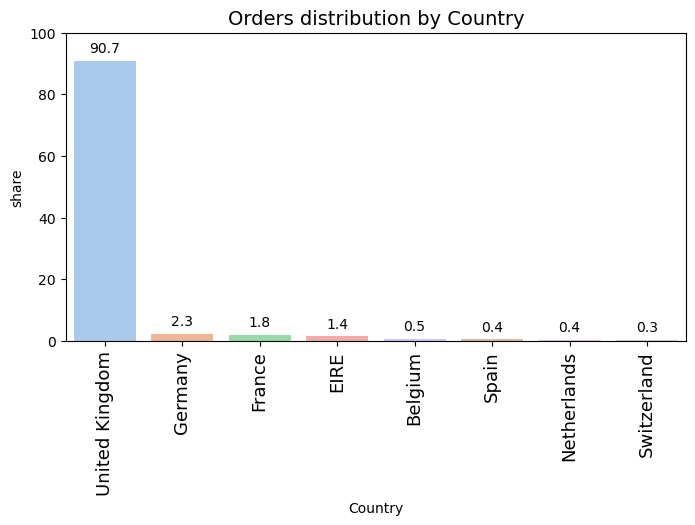

In [15]:
plt.figure(figsize=(8, 4))
splot = sns.barplot(x = obc_gb[:8].Country, 
                    y = obc_gb[:8].share)

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.ylim(0, 100)
splot.tick_params(axis='x', rotation=90, labelsize=13)
plt.title('Orders distribution by Country', fontsize=14)    
plt.show()

#### Productos distintos comprados por país

In [16]:
# Se filtra solo los campos que nos interesa
products_by_country =  df[['Country','StockCode']].copy()

In [17]:
# Creamos un objeto contando los productos distintos vendidos por país
dpbc_gb = products_by_country.groupby(by=["Country"])\
                             .agg({'StockCode':'nunique'})\
                             .rename(columns={'StockCode':
                                              'qty_products'})\
                             .reset_index()\
                             .sort_values(by='qty_products', 
                                          ascending=False)
dpbc_gb.head(10)

,Country,qty_products
36,United Kingdom,4065
10,EIRE,1976
14,Germany,1671
13,France,1543
31,Spain,1093
33,Switzerland,978
24,Netherlands,785
3,Belgium,778
27,Portugal,706
0,Australia,600


In [18]:
# Calculamos el porcentaje de productos distintos vendidos por país
# sobre el total
dpbc_gb['share'] = round(dpbc_gb['qty_products']/dpbc_gb['qty_products']\
                          .sum()*100,2)

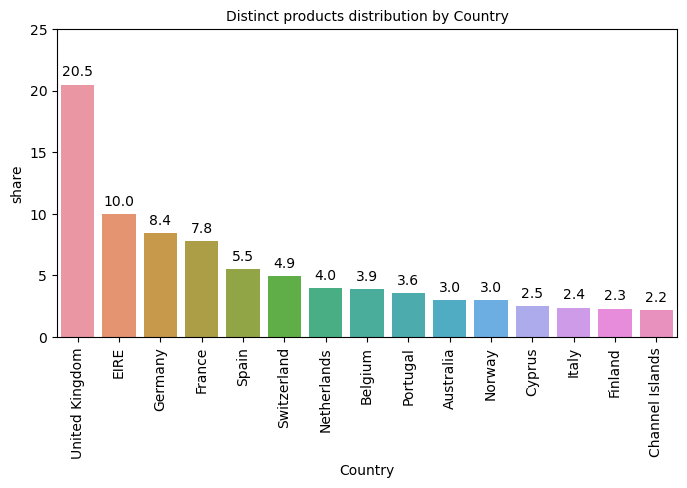

In [19]:
plt.figure(figsize=(8, 4))
splot = sns.barplot(x = dpbc_gb[:15].Country, 
                    y = dpbc_gb[:15].share)

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.ylim(0, 25)
splot.tick_params(axis='x', rotation=90, labelsize=10)
plt.title('Distinct products distribution by Country', fontsize=10)    
plt.show()

#### Órdenes y cantidad de productos

Debido a que nuestro algoritmo necesita encontrar relaciones entre productos que se compran con mayor frecuencia __juntos__, es importante analizar la distribución de la cantidad de productos que tienen las órdenes.

In [20]:
# Se filtran los campos de interés: StockCode y InvoiceNo
products_by_orders = df[['InvoiceNo','StockCode']].copy()
products_by_orders.sample(2)

,InvoiceNo,StockCode
169436,551174,22921
185900,552831,48194


In [21]:
# Se crea un objeto contabilizando la cantidad de productos por órden
pbo_gb = products_by_orders.groupby(by=["InvoiceNo"])\
                           .agg({'StockCode':'nunique'})\
                           .rename(columns={'StockCode':
                                            'qty_products'})\
                           .reset_index()\
                           .sort_values(by='qty_products', 
                                        ascending=True)
pbo_gb.head(10)

,InvoiceNo,qty_products
23671,C554477,1
22947,C545844,1
22948,C545846,1
4189,545433,1
22949,C545847,1
22950,C545848,1
22951,C545849,1
4184,545427,1
17193,571731,1
4181,545424,1


Existe un 22.76% de órdenes que solo tienen un producto:

In [22]:
round(len(pbo_gb[pbo_gb['qty_products'] == 1])/len(pbo_gb)*100,2)

22.76

In [23]:
dist_pbo = pbo_gb.groupby(by=["qty_products"])\
                 .agg({'InvoiceNo':'nunique'})\
                 .rename(columns={'InvoiceNo':
                                  'qty_orders'})\
                 .reset_index()\
                 .sort_values(by='qty_orders', 
                              ascending=False)
dist_pbo.head(5)

,qty_products,qty_orders
0,1,5894
1,2,1587
2,3,1083
3,4,810
4,5,792


In [24]:
dist_pbo['share'] = round(dist_pbo['qty_orders']/dist_pbo['qty_orders']\
                          .sum()*100,2)

Más allá de que hay una concentración del 22.76% de órdenes con 1 solo producto, se puede observar que hay una distribución bastante homogénea en el resto de las cantidades de productos comprados.

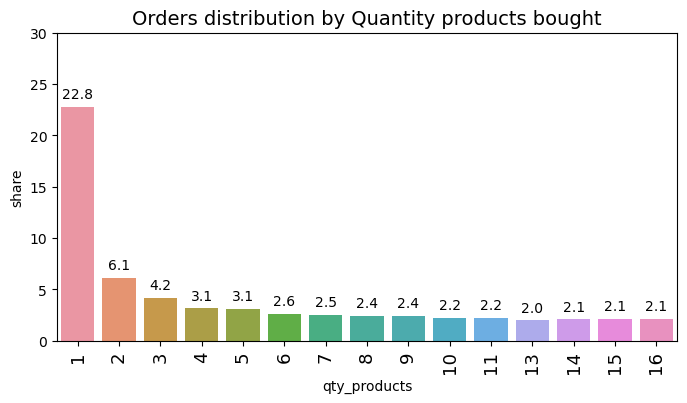

In [25]:
plt.figure(figsize=(8, 4))
splot = sns.barplot(x = dist_pbo[:15].qty_products, 
                    y = dist_pbo[:15].share)

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.ylim(0, 30)
splot.tick_params(axis='x', rotation=90, labelsize=13)
plt.title('Orders distribution by Quantity products bought', fontsize=14)    
plt.show()

Siguiendo con la distribución, se observa que la mediana es de 10 productos.
El máximo llama la atención por lo que indagaremos a qué se debe.

In [26]:
pbo_gb.describe()

,qty_products
count,25900.000000
mean,20.510618
std,42.500488
min,1.000000
25%,2.000000
50%,10.000000
75%,23.000000
max,1110.000000


In [27]:
# Identificamos el InvoiceNo que tenga 1110 productos
pbo_gb[pbo_gb['qty_products']==1110]

,InvoiceNo,qty_products
18141,573585,1110


Se puede observar que esta orden no tiene `CustomerID`, además tiene productos repetidos con distintas cantidades: `StockCode = 23221` tiene 2 registros, uno con `Quantity = 4` y otro con `Quantity = 1`. Es por ello que nos hace pensar que puede ser un agrupador de varias compras para varios usuarios.

In [28]:
# Luego filtramos por ese InvoiceNo en el dataframe original
df[df['InvoiceNo']=='573585']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
430237,573585,11001,ASSTD DESIGN RACING CAR PEN,2,2011-10-31 14:41:00,3.29,NaN,United Kingdom
430238,573585,15036,ASSORTED COLOURS SILK FAN,15,2011-10-31 14:41:00,1.63,NaN,United Kingdom
430239,573585,15039,SANDALWOOD FAN,15,2011-10-31 14:41:00,1.63,NaN,United Kingdom
430244,573585,16219,HOUSE SHAPE PENCIL SHARPENER,2,2011-10-31 14:41:00,0.83,NaN,United Kingdom
430245,573585,16235,RECYCLED PENCIL WITH RABBIT ERASER,2,2011-10-31 14:41:00,0.42,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
431345,573585,90202B,WHITE ENAMEL FLOWER HAIR TIE,1,2011-10-31 14:41:00,2.90,NaN,United Kingdom
431346,573585,90209C,PINK ENAMEL+GLASS HAIR COMB,3,2011-10-31 14:41:00,2.07,NaN,United Kingdom
431347,573585,90214S,"LETTER ""S"" BLING KEY RING",1,2011-10-31 14:41:00,0.83,NaN,United Kingdom
431348,573585,DOT,DOTCOM POSTAGE,1,2011-10-31 14:41:00,2019.05,NaN,United Kingdom


Se explorará aquellas órdenes que no tienen `CustomerID` para contabilizar la cantidad de productos por órden.

In [29]:
# Creamos un nuevo dataframe solo con los registros con customerID nulos.
nan_customer = df[df['CustomerID'].isna()].copy()
nan_customer = nan_customer[['InvoiceNo','StockCode']]

In [30]:
# Creamos un objeto contando los productos por orden para 
# cuando no tenemos identificados a los clientes
nc_gb = nan_customer.groupby(by=["InvoiceNo"])\
                    .agg({'StockCode':'nunique'})\
                    .rename(columns={'StockCode':
                                     'qty_products'})\
                    .reset_index()\
                    .sort_values(by='qty_products', 
                                 ascending=True)

In [31]:
nc_gb

,InvoiceNo,qty_products
0,536414,1
2314,561920,1
2315,561921,1
2316,561924,1
2317,561927,1
...,...,...
1977,558475,704
3478,580729,721
3522,581492,731
3511,581219,749


Sigue habiendo muchas órdenes con pocos productos en donde no se identifican los clientes. Por lo que puede indicar que no todos los registros sin `CustomerID` sean órdenes que agrupan compras de varios clientes. De hecho la mediana para este dataset filtrado es de 1 producto.

In [32]:
nc_gb.describe()

,qty_products
count,3710.000000
mean,36.265229
std,95.881790
min,1.000000
25%,1.000000
50%,1.000000
75%,9.000000
max,1110.000000


Por lo que volvemos a filtrar aquellas órdenes que cumplan con las siguientes condiciones:
* No tienen `CustomerID`
* Órdenes con más de 100 productos, considerando 100 productos una cantidad grande para ser de 1 solo usuario.

In [33]:
# Se crea una lista con los InvoiceNo que cumplan las 2 condiciones
# de especificadas arriba
orders_more_100_pdts = nc_gb[nc_gb['qty_products']>100].InvoiceNo.unique()

In [34]:
# Filtramos del dataset original por estos InvoiceNo
orders_more_100_pdts_customer_na = df[df['InvoiceNo']\
                                      .isin(orders_more_100_pdts)]

In [35]:
# Calculamos el porcentaje de estos casos respecto al total
round(len(orders_more_100_pdts_customer_na)/len(df)*100,2)

20.25

In [36]:
# Calculamos el porcentaje de órdenes respecto al total
round(orders_more_100_pdts_customer_na.InvoiceNo\
      .nunique()/df.InvoiceNo.nunique()*100,2)

1.63

__Conclusiones:__

1. borrar aquellos registros con 1 solo producto.

2. creo que sería mejor borrar estos registros pues pueden introducir ruido porque tienen varias órdenes de distintos usuarios juntos. Esto puede causar la errónea asociación de un producto del customer A con el producto comprado por el customer B que en realidad no deberían haberse comprado juntos.

### Preparar el dataset para el modelo

En el análisis realizado se definió las siguientes decisiones a tomar:
1. Filtrar el dataset solo para United Kingdom
2. Borrar las órdenes con 1 solo producto
3. Borrar las órdenes que potencialmente pueden ser para más de 1 cliente: sin CustomerID y con más de 100 productos por órden.
4. Borrar las descripciones duplicadas que están asociadas a 1 StockCode 


In [37]:
# 1. Filtramos solo para United Kingdom
df1 = df[df["Country"] == 'United Kingdom'].copy()

In [38]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 495478 entries, 6 to 541716
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    495478 non-null  object        
 1   StockCode    495478 non-null  object        
 2   Description  494024 non-null  object        
 3   Quantity     495478 non-null  int64         
 4   InvoiceDate  495478 non-null  datetime64[ns]
 5   UnitPrice    495478 non-null  float64       
 6   CustomerID   361878 non-null  float64       
 7   Country      495478 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 34.0+ MB


In [39]:
# 2. Borramos las órdenes con 1 solo producto
# 2.1 Recordemos que tenemmos el dataframe "pbo_gb" que contabilizada la cantidad de productos distintos por órden
pbo_gb.head(5)

,InvoiceNo,qty_products
23671,C554477,1
22947,C545844,1
22948,C545846,1
4189,545433,1
22949,C545847,1


In [40]:
# 2.2 Se crea un set de aquellos InvoiceNo con 1 solo producto
orders_with_1_product = pbo_gb[pbo_gb["qty_products"] == 1].InvoiceNo.unique()
orders_with_1_product = set(orders_with_1_product)

In [41]:
# 2.3 Luego filtramos el dataset de df1 
# eliminando aquellos registros que estén en la lista creada en el punto anterior
df1 = df1[~df1["InvoiceNo"].isin(orders_with_1_product)]
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 489874 entries, 6 to 541716
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    489874 non-null  object        
 1   StockCode    489874 non-null  object        
 2   Description  489874 non-null  object        
 3   Quantity     489874 non-null  int64         
 4   InvoiceDate  489874 non-null  datetime64[ns]
 5   UnitPrice    489874 non-null  float64       
 6   CustomerID   358755 non-null  float64       
 7   Country      489874 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.6+ MB


In [42]:
# 3.1 Recordemos que tenemos un dataframe con las órdenes que no tienen el CustomerID 
# y a su vez tienen más de 100 productos

orders_more_100_pdts_customer_na.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1845,536544,11001,ASSTD DESIGN RACING CAR PEN,3,2010-12-01 14:32:00,3.36,NaN,United Kingdom
1846,536544,16236,KITTY PENCIL ERASERS,1,2010-12-01 14:32:00,0.43,NaN,United Kingdom
1847,536544,16237,SLEEPING CAT ERASERS,4,2010-12-01 14:32:00,0.43,NaN,United Kingdom
1848,536544,16238,PARTY TIME PENCIL ERASERS,1,2010-12-01 14:32:00,0.43,NaN,United Kingdom
1849,536544,17003,BROCADE RING PURSE,3,2010-12-01 14:32:00,0.43,NaN,United Kingdom


In [43]:
# 3.2 Creamos un set con los InvoiceNo únicos

orders_more_100_pdts_customer_na = orders_more_100_pdts_customer_na.InvoiceNo.unique()
orders_more_100_pdts_customer_na = set(orders_more_100_pdts_customer_na)

In [44]:
# 3.3 Luego filtramos el dataset de df1 
# eliminando aquellos registros que estén en la lista creada en el punto anterior

df1 = df1[~df1["InvoiceNo"].isin(orders_more_100_pdts_customer_na)]
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380162 entries, 6 to 541716
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    380162 non-null  object        
 1   StockCode    380162 non-null  object        
 2   Description  380162 non-null  object        
 3   Quantity     380162 non-null  int64         
 4   InvoiceDate  380162 non-null  datetime64[ns]
 5   UnitPrice    380162 non-null  float64       
 6   CustomerID   358755 non-null  float64       
 7   Country      380162 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 26.1+ MB


In [45]:
# 4.1. Creamos un dataframe con las columnas StockCode y Description
products = df1[['StockCode','Description']].copy()
products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380162 entries, 6 to 541716
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   StockCode    380162 non-null  object
 1   Description  380162 non-null  object
dtypes: object(2)
memory usage: 8.7+ MB


In [46]:
# 4.2. Se elimina los duplicados
products.drop_duplicates(inplace=True)
products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3994 entries, 6 to 152578
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   StockCode    3994 non-null   object
 1   Description  3994 non-null   object
dtypes: object(2)
memory usage: 93.6+ KB


In [47]:
# 4.3. Volver a crear el objeto pdct_gb que indica los StockCodes con Descriptions duplicados
pdct_gb = products.groupby(by=["StockCode"])\
                  .agg({'Description':'nunique'})\
                  .rename(columns={'Description':'qty_descriptions'})\
                  .reset_index()\
                  .sort_values(by='qty_descriptions', ascending=False)
pdct_gb.head(10)

,StockCode,qty_descriptions
1966,23196,4
2006,23236,4
2867,17107D,3
2010,23240,3
1973,23203,3
1564,22776,3
2162,23413,3
2145,23396,3
1897,23126,3
1718,22937,3


In [48]:
# 4.4 Se elimina de la lista de productos aquellos que tienen más de una descripción asociado a un StockCode
products = products[~products['StockCode'].isin(pdct_gb[pdct_gb['qty_descriptions'] > 1]['StockCode'].unique())]
products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3570 entries, 6 to 152578
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   StockCode    3570 non-null   object
 1   Description  3570 non-null   object
dtypes: object(2)
memory usage: 83.7+ KB


In [49]:
# 4.5 Nos creamos un dataframe solo con los StockCodes que tienen más de un Description
stock_codes_w_more_1_description = pd.DataFrame(pdct_gb[pdct_gb['qty_descriptions'] > 1]['StockCode'].unique(),
                                                columns=['StockCode'])

In [50]:
# 4.6. Mergeamos con el dataframe df1 trayendo el campo Description
stock_codes_w_more_1_description = pd.merge(stock_codes_w_more_1_description['StockCode'],
                                            df1[['StockCode','Description']],
                                            how='left',
                                            on = 'StockCode')

In [51]:
stock_codes_w_more_1_description

,StockCode,Description
0,23196,RETRO LEAVES MAGNETIC NOTEPAD
1,23196,RETRO LEAVES MAGNETIC NOTEPAD
2,23196,RETRO LEAVES MAGNETIC NOTEPAD
3,23196,RETRO LEAVES MAGNETIC NOTEPAD
4,23196,RETO LEAVES MAGNETIC SHOPPING LIST
...,...,...
33510,71053,WHITE METAL LANTERN
33511,71053,WHITE METAL LANTERN
33512,71053,WHITE METAL LANTERN
33513,71053,WHITE METAL LANTERN


In [52]:
# 4.7. Eliminamos los duplicados generados por el merge del paso anterior
stock_codes_w_more_1_description.drop_duplicates(inplace=True)

In [53]:
stock_codes_w_more_1_description["Description"].unique()

array(['RETRO LEAVES MAGNETIC NOTEPAD',
       'RETO LEAVES MAGNETIC SHOPPING LIST',
       'LEAVES MAGNETIC  SHOPPING LIST', 'VINTAGE LEAF MAGNETIC NOTEPAD',
       'DOILEY STORAGE TIN', 'DOILEY BISCUIT TIN',
       'STORAGE TIN VINTAGE DOILEY ', 'STORAGE TIN VINTAGE DOILY ',
       "FLOWER FAIRY,5 SUMMER B'DRAW LINERS",
       'FLOWER FAIRY 5 DRAWER LINERS',
       'FLOWER FAIRY 5 SUMMER DRAW LINERS',
       'SET OF 4 KNICK KNACK TINS DOILEY ',
       'SET OF 4 KNICK KNACK TINS DOILY ',
       'SET OF 4 KNICK KNACK TINS  DOILEY ', 'JUMBO BAG DOILEY PATTERNS',
       'JUMBO BAG VINTAGE DOILEY ', 'JUMBO BAG VINTAGE DOILY ',
       'SWEETHEART CAKESTAND 3 TIER', 'CAKESTAND, 3 TIER, LOVEHEART',
       'SWEETHEART 3 TIER CAKE STAND ', 'VINTAGE COFFEE GRINDER BOX',
       'DECROTIVEVINTAGE COFFEE GRINDER BOX',
       'DECORATIVE VINTAGE COFFEE  BOX', 'BUTTERFLY CUSHION COVER',
       'LA JARDIN BOTANIQUE CUSHION COVER',
       'LE JARDIN BOTANIQUE CUSHION COVER', 'DOLLCRAFT GIRL AMELIE KIT

In [54]:
# 4.8. Se crea una columna "duplicates" que va rankeando por StockCode
stock_codes_w_more_1_description['duplicates'] = stock_codes_w_more_1_description.groupby(['StockCode']).cumcount()+1
stock_codes_w_more_1_description.sort_values(by=['StockCode','duplicates'])

,StockCode,Description,duplicates
25303,20622,VIPPASSPORT COVER,1
25325,20622,VIP PASSPORT COVER,2
10730,21109,"LARGE CAKE TOWEL, CHOCOLATE SPOTS",1
10734,21109,LARGE CAKE TOWEL CHOCOLATE SPOTS,2
10414,21112,"SWISS ROLL TOWEL, PINK SPOTS",1
...,...,...,...
13071,90014A,SILVER M.O.P. ORBIT NECKLACE,2
13055,90014B,GOLD M PEARL ORBIT NECKLACE,1
13061,90014B,GOLD M.O.P. ORBIT NECKLACE,2
13052,90014C,SILVER/BLACK ORBIT NECKLACE,1


In [55]:
# 4.9 Elminamos los duplicados (quedando solo con "duplicates" = 1) y borramos la columna "duplicates"
stock_codes_w_more_1_description = stock_codes_w_more_1_description[stock_codes_w_more_1_description['duplicates']==1].copy()
stock_codes_w_more_1_description.drop(labels=['duplicates'],
                                      axis=1,
                                      inplace=True)

In [56]:
stock_codes_w_more_1_description.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204 entries, 0 to 33245
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   StockCode    204 non-null    object
 1   Description  204 non-null    object
dtypes: object(2)
memory usage: 4.8+ KB


In [57]:
# 4.10. Unimos el dataset products (que solo tenía sin duplicados en Description)
# con este nuevo dataset stock_codes_w_more_1_description que dejamos sin duplicados
products_without_duplicates = pd.concat([products, stock_codes_w_more_1_description])
products_without_duplicates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3774 entries, 6 to 33245
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   StockCode    3774 non-null   object
 1   Description  3774 non-null   object
dtypes: object(2)
memory usage: 88.5+ KB


In [58]:
df2 = pd.merge(products_without_duplicates,
               df1,
               how='inner',
               on = ['Description','StockCode'])
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366749 entries, 0 to 366748
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   StockCode    366749 non-null  object        
 1   Description  366749 non-null  object        
 2   InvoiceNo    366749 non-null  object        
 3   Quantity     366749 non-null  int64         
 4   InvoiceDate  366749 non-null  datetime64[ns]
 5   UnitPrice    366749 non-null  float64       
 6   CustomerID   345953 non-null  float64       
 7   Country      366749 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 25.2+ MB


In [59]:
df2.drop_duplicates(inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361763 entries, 0 to 366748
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   StockCode    361763 non-null  object        
 1   Description  361763 non-null  object        
 2   InvoiceNo    361763 non-null  object        
 3   Quantity     361763 non-null  int64         
 4   InvoiceDate  361763 non-null  datetime64[ns]
 5   UnitPrice    361763 non-null  float64       
 6   CustomerID   340989 non-null  float64       
 7   Country      361763 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.8+ MB


In [60]:
pdct_gb = df2[['StockCode','Description']].groupby(by=["StockCode"])\
                                          .agg({'Description':'nunique'})\
                                          .rename(columns={'Description':'qty_descriptions'})\
                                          .reset_index()\
                                          .sort_values(by='qty_descriptions', ascending=False)
pdct_gb.head(10)

,StockCode,qty_descriptions
0,10002,1
2520,84352,1
2508,84051,1
2509,84077,1
2510,84192,1
2511,84199,1
2512,84212,1
2513,84218,1
2514,84226,1
2515,84227,1


In [61]:
# 4. Guardamos el dataset como model_input para usar en el siguiente notebook
df2.to_csv('C:/Users/josefina.lin/Documents/Master/10-Trabajo Final/datasets/model_input.csv', index = False)